# **Breast Cancer Classification using Principal Component Analysis (PCA) and Support Vector Machines (SVM)**

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import plotly.express as px

In [2]:
# Load the dataset
data = load_breast_cancer()
dfCancer = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [3]:
dfCancer.sample(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
523,13.710,18.68,88.73,571.0,0.09916,0.10700,0.05385,0.03783,0.1714,0.06843,...,15.11,25.63,99.43,701.9,0.1425,0.2566,0.19350,0.12840,0.2849,0.09031
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.1491,0.7584,0.67800,0.29030,0.4098,0.12840
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,...,10.23,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.2450,0.07773
155,12.250,17.94,78.27,460.3,0.08654,0.06679,0.03885,0.02331,0.1970,0.06228,...,13.59,25.22,86.60,564.2,0.1217,0.1788,0.19430,0.08211,0.3113,0.08132
457,13.210,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,0.05584,...,14.35,34.23,91.29,632.9,0.1289,0.1063,0.13900,0.06005,0.2444,0.06788


In [4]:
# Normalize the data using standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfCancer)

In [5]:
# Perform PCA.
# Obtain enough features to explian 90% of the variance
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

In [6]:
# Calculate the cumulative explained variance of the PCA model named "pca"
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

# A line plot is generated to visualize the cumulative variance
fig = px.line(x=range(1, len(cumulative_var)+1), y=cumulative_var,
              labels={'x': 'Number of Components', 'y':'Cumulative Explained Variance'},
              title='Cumulative Variance Explained by PCA Components')
fig.show()

In [7]:
# Get contributions of each feature to PC1
contributions_pc1 = pca.components_[0]

# Convert to DataFrame for visualization
df_contributions = pd.DataFrame({'feature': data.feature_names, 'contribution': contributions_pc1})
df_contributions

,feature,contribution
0,mean radius,0.218902
1,mean texture,0.103725
2,mean perimeter,0.227537
3,mean area,0.220995
4,mean smoothness,0.142590
5,mean compactness,0.239285
6,mean concavity,0.258400
7,mean concave points,0.260854
8,mean symmetry,0.138167
9,mean fractal dimension,0.064363


In [8]:
import plotly.graph_objects as go
num_components = len(pca.components_)

# Convert to DataFrame for visualization
contributions = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, num_components+1)], index=data.feature_names)

# Get contributions of each feature to each PC as percentages
contributions = pca.components_**2
contributions /= contributions.sum(axis=1, keepdims=True)
contributions *= 100  # convert to percentage
dfContributions = pd.DataFrame(contributions.T, columns=[f'PC{i}' for i in range(1, num_components+1)], index=data.feature_names)

# Create figure
fig = go.Figure()

# Add traces for each Principal component
for i, pc in enumerate(dfContributions.columns, start=1):
    fig.add_trace(go.Bar(x=dfContributions.index, y=dfContributions[pc], name=pc))

# Update traces to be visible only for the corresponding slider step
steps = []
for i, pc in enumerate(dfContributions.columns, start=1):
    step = dict(
        method="update",
        args=[{"visible": [el == pc for el in dfContributions.columns]},
              {"title": f"Contributions to Principal Component: {pc}"}],
        label=pc,
    )
    steps.append(step)

# Create and add slider
sliders = [dict(active=1, pad={"t": 100}, steps=steps)]

fig.update_layout(sliders=sliders)

# Set first title
fig.update_layout(title=f"Contributions by Percent to Principal Component: Mixed", xaxis_title="Feature", yaxis_title="Contribution")

# Show plot
fig.show()

In [9]:
random.seed(10)

# Look at SVM with fewer components
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9736842105263158
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [10]:
# Reduce to two dimensions so we can visualize the SVM
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

In [11]:
random.seed(10)

# This assumes you used teh name pca_2 for your new PCA
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_pca_2, y, test_size=0.2, random_state=42)

model_2 = SVC(kernel='linear')
model_2.fit(X_train_2, y_train_2)

SVC(kernel='linear')

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

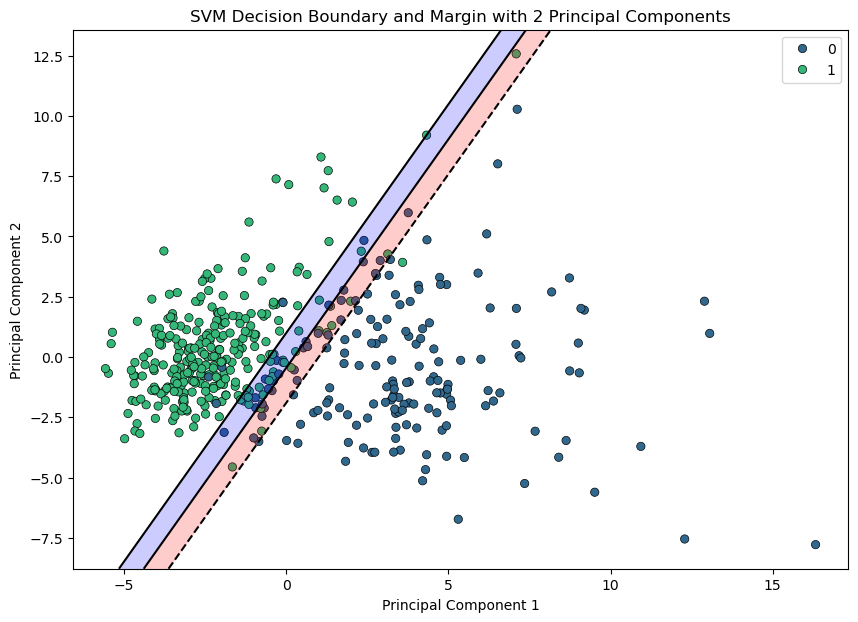

In [13]:
# Use the PCA and SVM from previous steps
# Create grid to plot decision boundaries and margins
x_min, x_max = X_pca_2[:, 0].min() - 1, X_pca_2[:, 0].max() + 1
y_min, y_max = X_pca_2[:, 1].min() - 1, X_pca_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict decision function on the grid
Z = model_2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot using Seaborn and Matplotlib
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_train_2[:, 0], y=X_train_2[:, 1], hue=y_train_2, palette="viridis", edgecolor="k")

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['red', 'blue', 'red'])
plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors='black')

plt.title('SVM Decision Boundary and Margin with 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [14]:
# Calculate the cumulative explained variance of the first four components
cumulative_variance_first_four = np.sum(pca.explained_variance_ratio_[:4])
print("Cumulative explained variance of the first four principal components:", cumulative_variance_first_four)

Cumulative explained variance of the first four principal components: 0.7923850582446096
